# General

In [13]:
# imports
from scipy.optimize import curve_fit
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
Absorption_folder = 'Absorption_Data'
from scipy.constants import c, h


# run the GeneralAnalyisis note book
%run -i C:\Users\yaniv\Jupyter_staff/Data_analezis/GeneralAnalysis.ipynb

# imports
from scipy import stats
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, peak_widths

from scipy.special import erf

from scipy.optimize import minimize, fsolve

# Functions

In [3]:
def get_data(file_path, dark = False, cali = False, cut = [506,545]):
    '''
    take raw data and transform it to pd data frame 
    '''
    cali_params1 = [-5.752597903601357, 1.0042432321536299]
    cali_func1 = lambda x: cali_params1[1] * x + cali_params1[0]
    
    data = pd.read_csv(file_path, delimiter='\t' ,names = ['x', 'y'])
    
    if cali:
        data['x'] = cali_func1(data['x'])
        
    data = data[(data['x'] > cut[0]) & (data['x'] < cut[1])]

    if dark:
        data['y'] = data['y'] - dark_data['y']
    return data

def calc_absorption(data):
    '''
    calculate absorption from raw data
    '''
    return np.array(-np.log10(data['y']/blank_data['y']))

def wavelength_to_wavenumber(wavelength):
    return 1 / wavelength * 1e7 # nm to cm^-1

def plot_spectrom(data, title = 'Spectrum', x_type = 'nm'):
    if x_type == 'cm^-1':
        x_label = r'Wavenumber [$cm^{-1}$]'
        data['x'] = wavelength_to_wavenumber(data['x'])
    else:
        x_label = 'Wavelength [nm]'

    plt.plot(data['x'], data['y'])
    plt.title(title, fontsize=18)
    plt.xlabel(x_label)
    plt.ylabel('Intensity [a.u.]')
    plt.show()

def linear_func(x, a, b):
    return a * x + b

def Birge_Sponer (peaks_df,show_ext = False, title =''):
    # Perform the curve fit
    popt, pcov = curve_fit(linear_func, peaks_df['level'] + 1, peaks_df['Deltawavenumber'])

    # Extract the fitting parameters
    a, b = popt
    da, db = np.sqrt(np.diag(pcov))

    # Plot the data and the fit
    plt.plot(peaks_df['level'] + 1, peaks_df['Deltawavenumber'], '.', label='Data')
    plt.plot(peaks_df['level'] + 1, linear_func(peaks_df['level'] + 1, *popt), '-', label='Fit')
    plt.xlabel(r'$\nu + 1$')
    plt.ylabel(r'$\Delta\widetilde{\nu}$ [cm$^{-1}$]')
    plt.title('The Birge-Sponer Extrapolation' + title, fontsize=18)


    #culate things
    ve, dve = b, db
    vexe, dvexe = - a / 2, da / 2
    D0, dD0 = - b ** 2 / (2 * a), np.sqrt((b * db / a) ** 2 + (b ** 2 * da / (2 * a ** 2)) ** 2)
    De, dDe = D0 + ve / 2, np.sqrt(dD0 ** 2 + (dve / 2) ** 2)

    vdelta =  peaks_df['level'].values[0] + 1
    A,dA = 1 /2 * (a * vdelta + b) * (-b/a - vdelta), np.sqrt((1 /2 * (a * vdelta + b) * (-b/a - vdelta))**2 * ( (db / 2)**2 + (da * vdelta / 2)**2) + (1 /2 * (a * vdelta + b) * (-b/a - vdelta) * (a * vdelta / 2))**2)
    E_star, dE_star = A + peaks_df['Deltawavenumber'].values[0], np.sqrt(dA ** 2 + peaks_df['Deltawavenumber'].values[0] ** 2)

    if show_ext:
        v_show = np.linspace(0, -b/a, 100)
        plt.plot(v_show, a * v_show + b, '--', color = 'tab:orange', label='Ext.')
        v_show2 = np.linspace(vdelta, -b/a, 100)
        # plt.fill_between(v_show, a * v_show + b, alpha=0.2, color='tab:green', label=r'$D_0 ^{\prime}$')
        plt.fill_between(v_show2, a * v_show2 + b, alpha=0.2, color='tab:orange', label='A')
        plt.xlim(0)
        plt.ylim(0)

    plt.legend()
    plt.show()
    return ve, dve, vexe, dvexe, D0, dD0, De, dDe, E_star, dE_star

def do_the_thing(file_path, n1 = 23, title = '', **kwargs):
    data = get_data(file_path, cali = True)
    wavelength = np.array(data['x'])
    absorption = calc_absorption(data)
    peaks, _ = find_peaks(absorption, height = 0.1)
    plt.plot(wavelength, absorption)
    plt.scatter(wavelength[peaks], absorption[peaks], c = 'r', marker = 'x')
    
    plt.title('Absorption Spectrum' + title, fontsize=18)
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Absorption [a.u.]')
    # plt.xlim(510, 550)
    # plt.xlim(500, 510)
    
    # plt.vlines([541.2,536.9], 0.35,0.45 , color = 'g', linestyle = '--')
    # plt.vlines(wavelength[[peaks[23],peaks[25]]], 0.35,0.45 , color = 'b', linestyle = '--')
    ylim = plt.gca().get_ylim()
    plt.vlines(541.2, ylim[0],ylim[1] , color = 'tab:green', linestyle = '--', label = r'$\nu ^{\prime} = 27$')
    plt.vlines(536.9, ylim[0],ylim[1] , color = 'tab:orange', linestyle = '--', label = r'$\nu ^{\prime} = 29$')
    plt.legend()
    plt.show()
    
    v1 = 29
    
    N = len(peaks)
    levels = np.arange(v1+n1,v1+n1-N,-1)
    # print(levels)
    # print(wavelength[[peaks[23],peaks[25]]])
    peaks_df = pd.DataFrame({'wavelength': wavelength[peaks], 'absorption': absorption[peaks], 'wavenumber': wavelength_to_wavenumber(wavelength[peaks]), 'level': levels})
    peaks_df['Deltawavenumber'] = abs(peaks_df['wavenumber'].diff())
    # display(peaks_df)
    peaks_df = peaks_df.dropna()
    ve, dve, vexe, dvexe, D0, dD0, De, dDe, E_star, dE_star = Birge_Sponer(peaks_df, title=title,  **kwargs)
    print('Results' + title +':')
    print('ve = {:.2f} ± {:.2f} cm^-1'.format(ve, dve))
    print('vexe = {:.2f} ± {:.2f} cm^-1'.format(vexe, dvexe))
    print('D0 = {:.2f} ± {:.2f} cm^-1'.format(D0, dD0))
    print('De = {:.2f} ± {:.2f} cm^-1'.format(De, dDe))
    print('E* = {:.2f} ± {:.2f} cm^-1'.format(E_star, dE_star))
    return [ve, dve, vexe, dvexe, D0, dD0, De, dDe, E_star, dE_star]

def culc_B(dv, J):
    mu = 2.1072803e-25 / 2 # iodine mu in kg
    B = dv / (2 * (2* J + 1))
    R = np.sqrt(h/(8 * np.pi**2 * c * B * mu)) * 1e-11 # in Angstrom
    print('B = {:.2f} cm^-1'.format(B))
    print('R = {:.2f} Angstrom'.format(R))
    return B, R
    

## Hydrogen Func

In [33]:
def get_data(file_path):
    '''
    take raw data (txt) and transform it to pd data frame 
    '''
    return pd.read_csv(file_path, delimiter = '\t', names = ['x', 'y'])

def gaussian(x, mu, sigma, amp):  # gaussian function
    return amp * np.exp(-(x - mu) ** 2 / sigma ** 2)

def bigaussian(x, mu1, sigma1, amp1,  mu2, sigma2, amp2, y0):
    return gaussian(x, mu1, sigma1, amp1) + gaussian(x, mu2, sigma2, amp2) + y0

no_cali_func = lambda x : x  # imitial cali function

def linear_func(x,a0,a1): # define the modle fucntion - linear
    return a1 * x + a0

def linear_func2(p,x): # define the modle fucntion - linear
    a0, a1 = p
    return a0 + a1 * x

FWHM = lambda sigma : 2 * np.sqrt(2 * np.log(2)) * sigma  # Calculate Full width at half maximum from sigma of gaussian 

def fit_gaussian(data):
    """
    Fits a Gaussian to a given data and reterns fitted prameters, fitted function and Goodnes of fit and graph (optional)

    Prameters: 
    data: x, y pandas Data frame

    Returns: 
    params (list): [mu, sigma, amp]
    params_error (list): [mu_err, sigma_err, amp_err]
    fitted_gaussian (func): Gaussian function with fitted parameters
    
    """
    x_data, y_data = data['x'], data['y']  # call data

    # Initial guess for the parameters [amplitude, center, width]
    initial_guess = [np.mean(x_data), np.std(x_data), max(y_data)]

    # Preform the curve fit
    params, pcov = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
    params[1] = abs(params[1])
    # extract params errors 
    params_error = np.sqrt(np.diag(pcov))
    
    # define fitted gaussian
    fitted_gaussian = lambda x: gaussian(x, *params)

    return params, params_error, fitted_gaussian

def multy_fit(file_list, folder_path, cali_func = no_cali_func ,plot = False):
    '''
    irritate over the file in flie_list and returns wave_length, FWHM, Peak intensity and errors

    Parameters:
    file_list (list): list of file to collect
    folder_path (string): path of the folder containing the files
    cali_func (function): calibration function for wave length
    plot = True if you wish to plot the fitted graphs
    
    Returns:
    Pandas Data frame: wave length, FWHM, FWHM err, intensity, intensity err
    '''
    df = pd.DataFrame({'wave length':[],'FWHM':[],'FWHM err':[],'intensity':[],'intensity err':[]})
    
    for file in file_list:  # irritate over the files
        file_path = os.path.join(folder_path, file)  # find file path
        Data = get_data(file_path)  # Extract data from file
        params, params_err, fitted_gaussian =  fit_gaussian(Data)  # fit gaussian to the data and collect the fitted parameter
        new_row = [cali_func(params[0]), FWHM(params[1]), FWHM(params_err[1]), params[2], params_err[2]]  # the new row in the data frame
        df.loc[len(df.index)] = new_row  # add new row to data frame

        if plot:  # if plot = True: plot a graph
            plot_DF(Data, fitted_gaussian, title = file)

    return df

def fit_bigaussian(data, initial_guess):
    """
    Fits a Double Gaussian to a given data and reterns fitted prameters, fitted function and Goodnes of fit and graph (optional)

    Prameters: 
    data: x, y pandas Data frame

    Returns: 
    params1 (list): [mu1, sigma1, amp1]
    params1_error (list): [mu_err1, sigma_err1, amp_err1]
    params2 (list): [mu2, sigma2, amp2]
    params2_error (list): [mu_err2, sigma_err2, amp_err2]
    
    fitted_gaussian (func): bigaussian function with fitted parameters
    
    """
    x_data, y_data = data['x'], data['y']  # call data

    # Initial guess for the parameters [amplitude, center, width]
    #initial_guess = [np.mean(x_data), np.std(x_data), max(y_data), np.mean(x_data) + 0.2, np.std(x_data), max(y_data) / 5]

    # Preform the curve fit
    Gparams, pcov = curve_fit(bigaussian, x_data, y_data, p0=initial_guess)
    Gparams[1], Gparams[4] = abs(Gparams[1]), abs(Gparams[4])
    # extract params errors 
    Gparams_error = np.sqrt(np.diag(pcov))
    
    # define fitted gaussian
    fitted_bigaussian = lambda x: bigaussian(x, *Gparams)

    return Gparams, Gparams_error, fitted_bigaussian

                                   
def plot_DF(data, fit_func, title = "Graph", sep = True):
    '''
    plot data and fit 
    '''
    # plot data points
    x_data, y_data = data['x'], data['y']  # call data
    
    plt.plot(x_data, y_data, '.', label = 'Data')

    # plot fitted gaussian
    x_show = np.linspace(min(x_data), max(x_data), 1000)
    plt.plot(x_show, fit_func(x_show), label = 'fitted function')
    
    plt.legend(loc='best')
    plt.grid()
    plt.xlabel('Wave length [nm]')
    plt.ylabel('Intensity [mV]')
    plt.title(title, fontsize=18)
    plt.show(sep)


# Files

In [2]:

# plot_spectrom(dark_data, title = 'Dark Spectrum', x_type = 'nm')
# plot_spectrom(blank_data, title = 'Blank Spectrum', x_type = 'nm')


# Analyzis

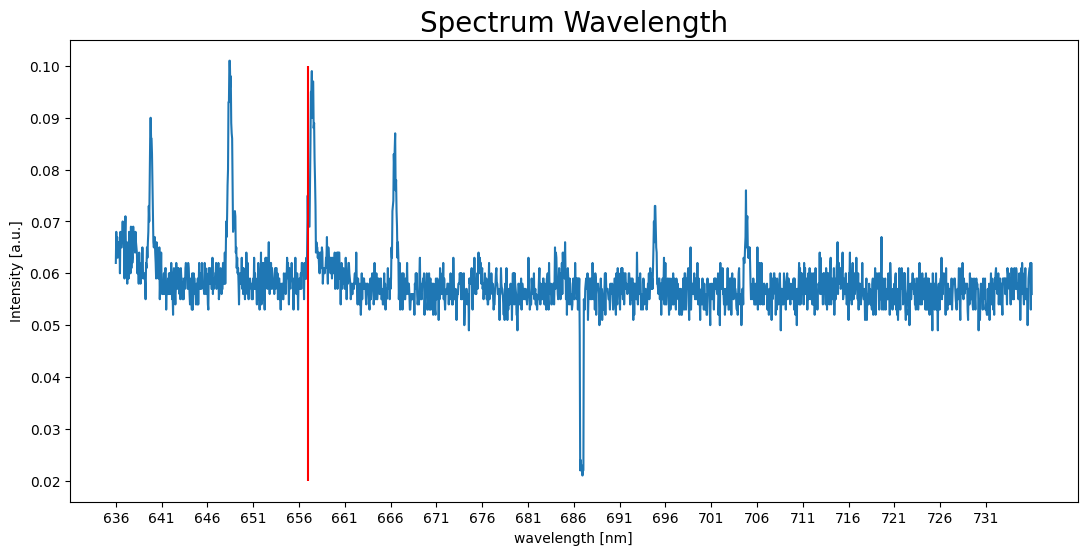

In [53]:
file = r'LEF_data\ROUGH_SCAN.csv'
data = pd.read_csv(file, delimiter='\t', names=['x', 'y'])
# data = get_data(file_path=file, dark=False, cali= False)
wavelength = data['x']
wavenamber = wavelength_to_wavenumber(wavelength)
intensity = data['y']

# plt.figure(figsize=(13, 6))  # Increase the figure size
# plt.plot(wavenamber, intensity)
# plt.xlabel(r'Wavenamber [$cm^{-1}$]')
# plt.ylabel('Intensity [a.u.]')
# plt.title('Spectrum Wavenumber', size = 20)
# # plt.xlim(640)
# plt.show()

plt.figure(figsize=(13, 6))  # Increase the figure size
plt.plot(wavelength, intensity)
plt.xlabel(r'wavelength [nm]')
plt.ylabel('Intensity [a.u.]')
plt.title('Spectrum Wavelength', size = 20)
plt.xticks(np.arange(min(wavelength), max(wavelength), 5))
plt.vlines(657,0.02,0.1, color = 'r')
# plt.xlim(655,660)
plt.show()

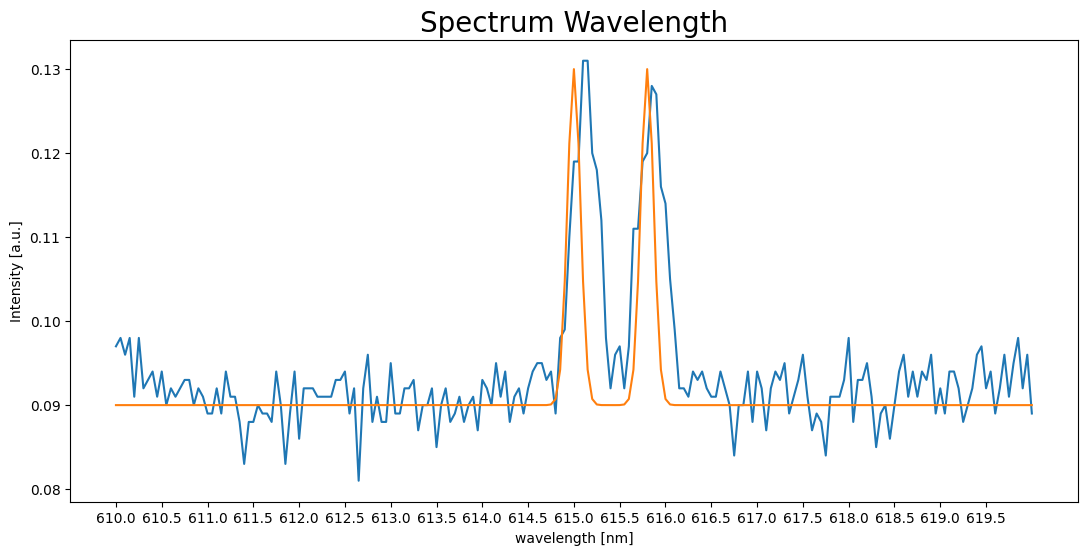

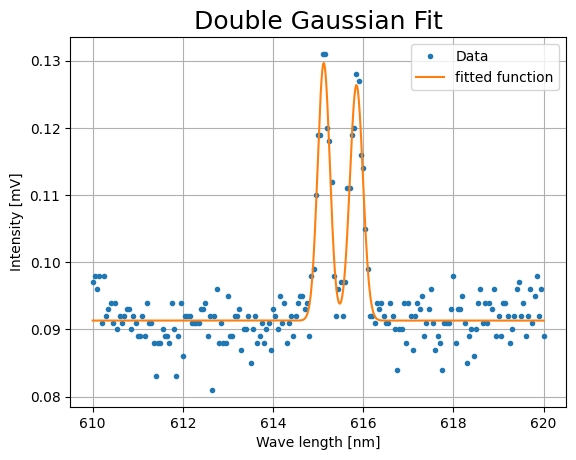

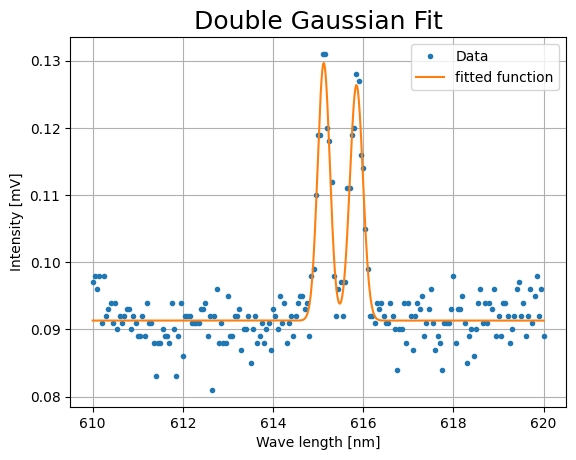

In [35]:
file = r'LEF_data\predublet.csv'
data = pd.read_csv(file, delimiter='\t', names=['x', 'y'])
# data = get_data(file_path=file, dark=False, cali= False)
wavelength = data['x']
wavenamber = wavelength_to_wavenumber(wavelength)
intensity = data['y']

a, b = 610, 620
filtered_data = data[(data['x'] >= a) & (data['x'] <= b)]
wavelength = filtered_data['x']
intensity = filtered_data['y']


initial_geuss = [615, 0.1, 0.04,  615.8, 0.1, 0.04, 0.09]
fitted_bigaussian = lambda x: bigaussian(x, *initial_geuss)


plt.figure(figsize=(13, 6))  # Increase the figure size
plt.plot(wavelength, intensity)
plt.plot(wavelength, fitted_bigaussian(wavelength))

plt.xlabel(r'wavelength [nm]')
plt.ylabel('Intensity [a.u.]')
plt.title('Spectrum Wavelength', size = 20)
plt.xticks(np.arange(min(wavelength), max(wavelength), 0.5))
# plt.vlines(657,0.02,0.1, color = 'r')
# plt.xlim(655,660)

plt.show()


params, params_err, fitted_bigaussian = fit_bigaussian(filtered_data, initial_geuss)
plot_DF(filtered_data, fitted_bigaussian, title = 'Double Gaussian Fit')



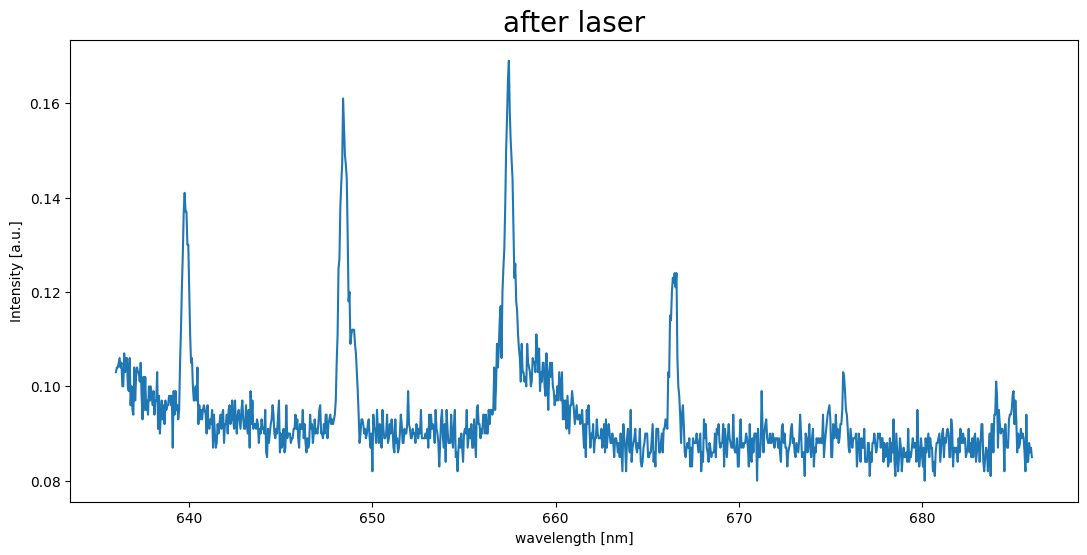

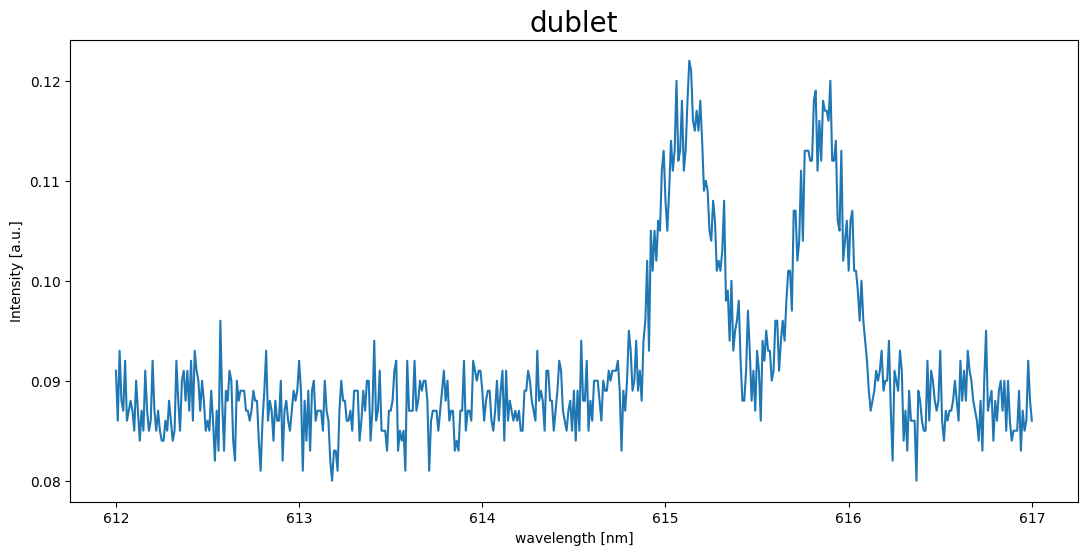

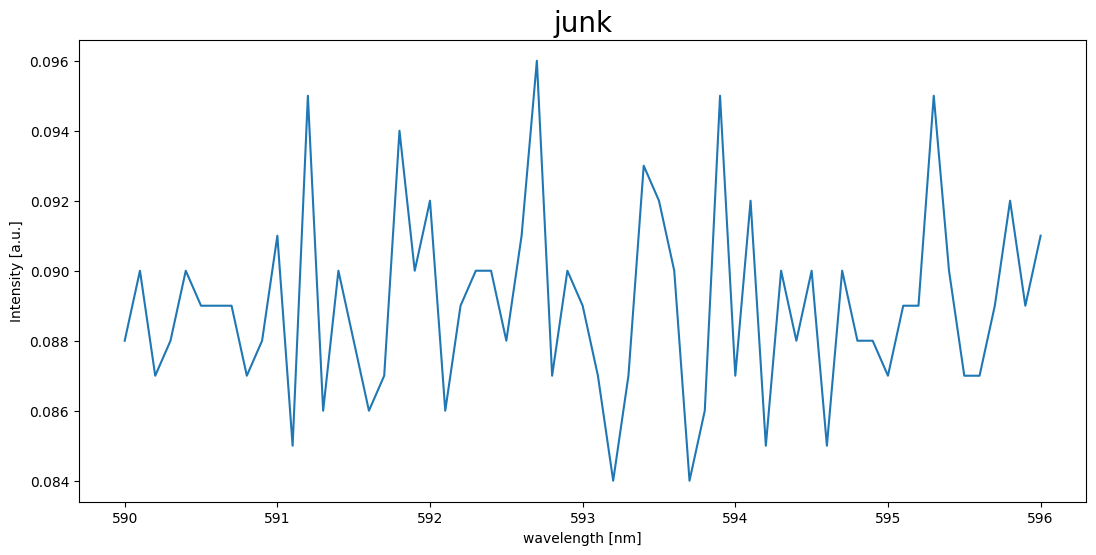

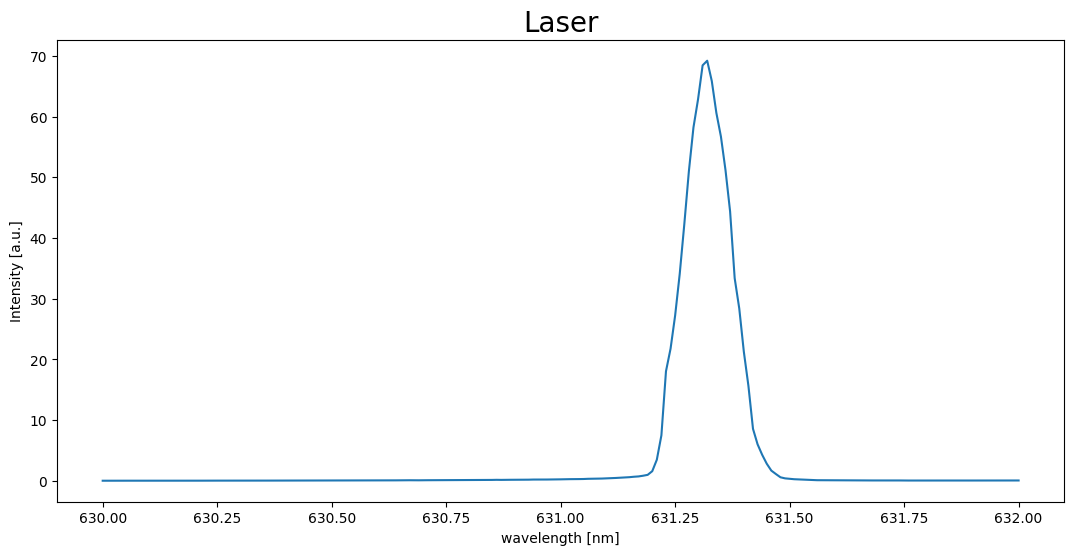

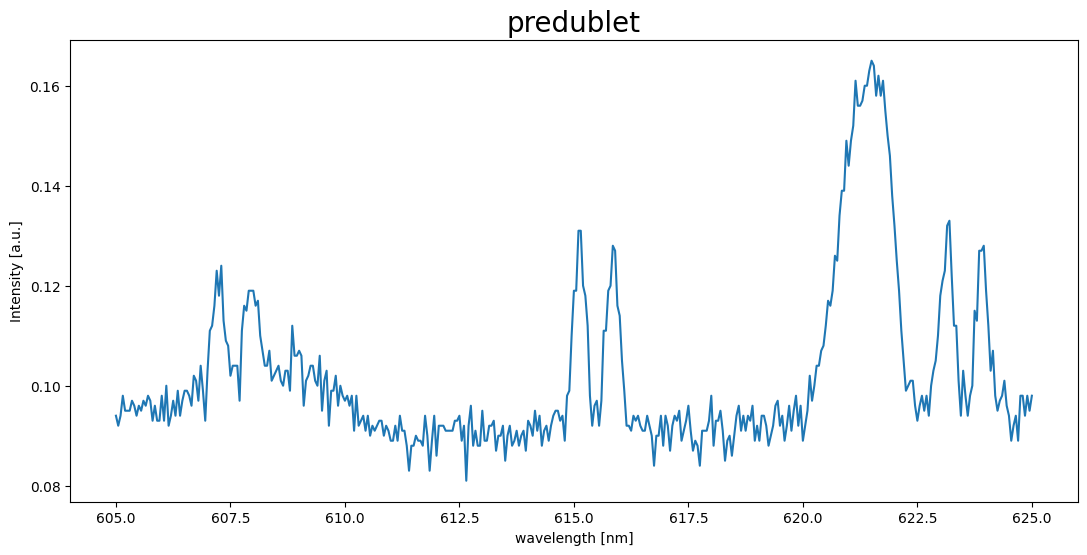

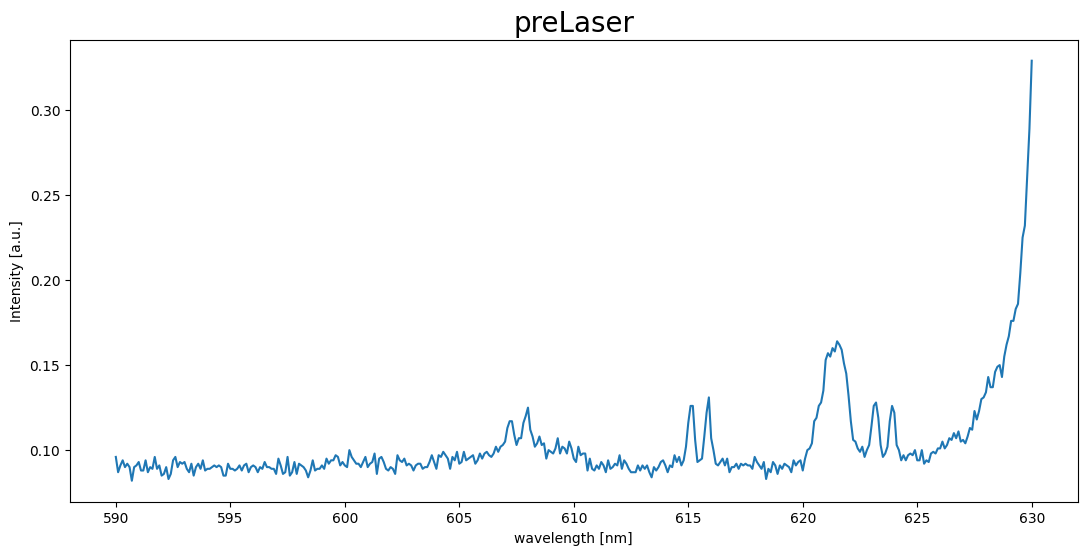

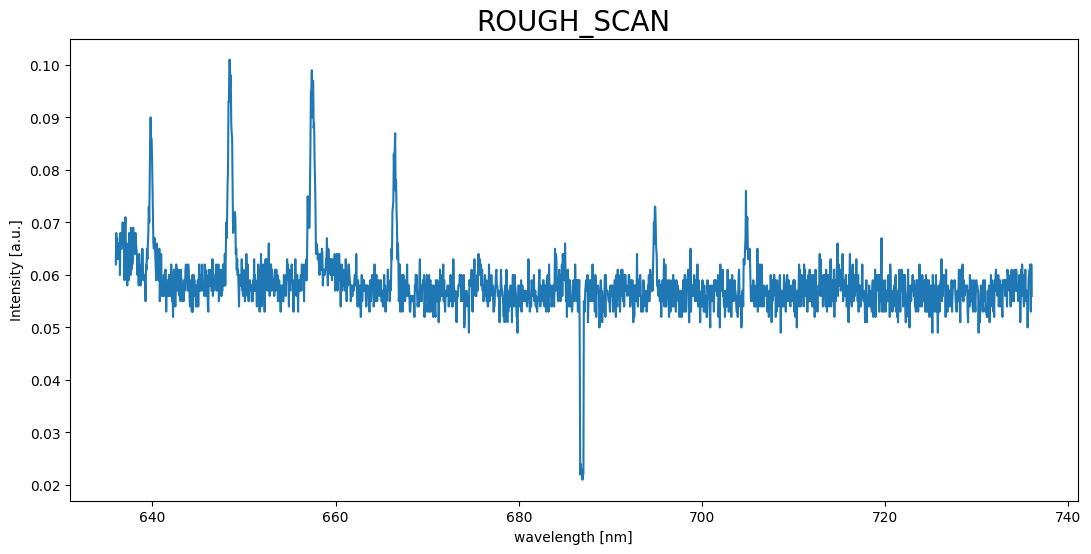

In [9]:
folder = 'LEF_data'
files = os.listdir(folder)
files = [file for file in files if file.endswith('.csv')]
for file in files:
    data = pd.read_csv(os.path.join(folder,file), delimiter='\t', names=['x', 'y'])
    # data = get_data(file_path=file, dark=False, cali= False)
    wavelength = data['x']
    wavenamber = wavelength_to_wavenumber(wavelength)
    intensity = data['y']

    plt.figure(figsize=(13, 6))  # Increase the figure size
    plt.plot(wavelength, intensity)
    plt.xlabel(r'wavelength [nm]')
    plt.ylabel('Intensity [a.u.]')
    title = file.split('.')[0]
    plt.title(title, size = 20)
    plt.show()
